# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [127]:
import pandas as pd

In [128]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [129]:
import seaborn as sns

In [130]:
import urllib2
import bs4
from bs4 import BeautifulSoup

In [131]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [132]:
soup = BeautifulSoup(urllib2.urlopen(URL).read(), "html.parser")

In [133]:
# print soup.prettify()

In [134]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York"
url_next = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10&pp="
URL_base = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York"

def get_URL(min_n, max_n):
    max_results_per_city = max_n
    res=[]
    for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami']):
        for start in range(min_n, max_results_per_city, 100):
            url = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={"+city+"}&start={"+str(start)+"}&limit=100"
            res.append(url)
            # Grab the results from the request (as above)
            # Append to the full set of results
            pass
    return res
urls = get_URL(0,100)

In [135]:
def slip_dollar(a):
    a = '$' + a
    return a
slip_dollar("1000")

'$1000'

In [136]:
new_df = pd.DataFrame(columns = ['title', 'company', 'location', 'salary', 'summary', 'ratings'])

In [137]:
for url in urls:
    html = urllib2.urlopen(url).read()
    soup = BeautifulSoup(html, "html.parser")
    for job in soup.find_all('div', {"class":" row result"}):
        try:
            salary = job.find("td", {"class":"snip"}).find('nobr').renderContents()
        except:
            salary = "NA"
        if salary != "NA":
            title = job.find("a",{"target":"_blank"}).get("title")
            company = job.find("span", {"itemprop":"name"}).getText()
            company = company.replace(' ', '').replace("\n", "")
            location = job.find("span", {"class":"location"}).text.strip()
            summary = job.find("span", {"class":"summary"}).text.strip()
            rating = job.find("span", {"class":"rating"})
            new_df.loc[len(new_df)] = [title, company, location, salary, summary, rating]

## Number of unique companies, locations, and titles.

In [138]:
new_df.title.duplicated().sum()

14

In [139]:
len(new_df.company.unique()), len(new_df.location.unique()), len(new_df.title.unique())

(100, 63, 143)

In [140]:
import pandas as pd

## Cities ranked by number of postings

In [141]:
len(new_df.location[new_df.location== 'Coral Gables, FL'].index)

11

In [142]:
def comma(num):
    '''Add comma to every 3rd digit. Takes int or float and
    returns string.'''
    if type(num) == int:
        return '{:,}'.format(num)
    elif type(num) == float:
        return '{:,.2f}'.format(num) # Rounds to 2 decimal places
    else:
        print("Need int or float as input to function comma()!")
        

In [143]:
split_city= new_df.location.str.split(' ', expand=True)

In [144]:
split_city = split_city.iloc[:, 0:2]
split_city[0] = split_city[0].replace(',','')
split_city[1] = split_city[1].replace(',','')

In [145]:
new_df.location = split_city[0].str.cat(split_city[1])

In [146]:
new_df.location.unique()

array([u'Houston,TX', u'DeerPark,', u'Phoenix,AZ', u'Tempe,AZ',
       u'Scottsdale,AZ', u'Chicago,IL', u'Northbrook,IL', u'SanFrancisco,',
       u'SanRamon,', u'Oakland,CA', u'RedwoodCity,', u'NewYork,',
       u'Manhattan,NY', u'Dallas,TX', u'Richardson,TX',
       u'Dallas-FortWorth,', u'Irving,TX', u'Philadelphia,PA',
       u'SpringHouse,', u'Radnor,PA', u'Denver,CO', u'Aurora,CO',
       u'BuckleyAFB,', u'Boulder,CO', u'Englewood,CO', u'LosAngeles,',
       u'RowlandHeights,', u'Pittsburgh,PA', u'CoralGables,',
       u'MiamiLakes,', u'FortLauderdale,', u'Miami,FL', u'Atlanta,GA',
       u'Seattle,WA', u'Bellevue,WA', u'Austin,TX', u'Leander,TX',
       u'Portland,OR', u'Tualatin,OR', u'Beaverton,OR', u'Vancouver,WA'], dtype=object)

In [147]:
new_df[["company", "location", "salary"]].groupby("location").count().sort_values(by='salary', ascending = False)

,company,salary
location,,
"Austin,TX",17,17
"NewYork,",15,15
"Atlanta,GA",12,12
"Phoenix,AZ",11,11
"CoralGables,",11,11
"LosAngeles,",9,9
"Houston,TX",7,7
"Portland,OR",7,7
"Denver,CO",7,7


In [148]:
new_df.salary.str.contains('year').sum()

123

In [149]:
new_df = new_df[new_df.salary.str.contains('year')==True]
new_df.salary = new_df.salary.str.replace("$", "")

In [150]:
new_df.salary = new_df.salary.str.rstrip()
new_df.salary = new_df.salary.str.replace(" a year", "")
new_df[['sal1','sal2']]= new_df.salary.str.split('-', expand=True)
new_df.salary = new_df['sal1']

In [151]:
new_df = new_df.drop(new_df[['sal1','sal2']], axis=1)


In [152]:
new_df.salary = new_df.salary.str.replace(',','')
new_df.salary = new_df.salary.astype(float)

## Titles ranked by pay

In [153]:
df_groupby_salary_title = new_df[['title','salary']].groupby('title', as_index=True).mean().sort_values(by='salary', ascending = False)

In [154]:
df_groupby_salary_title['salary_commas'] = df_groupby_salary_title['salary'].astype(int)
df_groupby_salary_title['salary_commas'] = df_groupby_salary_title['salary_commas'].apply(comma)
df_groupby_salary_title['salary_commas'] = df_groupby_salary_title['salary_commas'].apply(slip_dollar)

In [155]:
df_groupby_salary_title.head(10)

,salary,salary_commas
title,,
C++ Software Engineer,250000.0,"$250,000"
"Sr. Director, Statistical Innovation",220000.0,"$220,000"
Quantitative Researcher – Machine Learning,200000.0,"$200,000"
Data Science Director,180000.0,"$180,000"
Senior Data Scientist - Security Experience is Huge,170000.0,"$170,000"
"Program Manager - Data Science - New York City - $165,000",165000.0,"$165,000"
Director of Data Science,160000.0,"$160,000"
Senior Business Systems Architect (Hadoop Developer),155000.0,"$155,000"
Data Services Engineer,150000.0,"$150,000"


In [156]:
df_groupby_salary_title.tail(10)

,salary,salary_commas
title,,
Financial Analyst (Clinical Research Revenue),38750.0,"$38,750"
(Temporary) Research Analyst,38750.0,"$38,750"
SENIOR STATISTICAL CLERK,36339.0,"$36,339"
Food Scientist: Chemistry & Formulations,35000.0,"$35,000"
Research and Investigation Analyst,35000.0,"$35,000"
Statistical Programmer,32900.0,"$32,900"
Program Statistician,30732.0,"$30,732"
Research Technician,30732.0,"$30,732"
(Temporary) Research Laboratory Technician,27400.0,"$27,400"


## Companies rank by pay

In [157]:
df_groupby_salary_company = new_df[['company','salary']].groupby('company', as_index=True).mean().sort_values(by='salary', ascending = False)

In [158]:
df_groupby_salary_company['salary_commas'] = df_groupby_salary_company['salary'].astype(int)
df_groupby_salary_company['salary_commas'] = df_groupby_salary_company['salary_commas'].apply(comma)
df_groupby_salary_company['salary_commas'] = df_groupby_salary_company['salary_commas'].apply(slip_dollar)

In [159]:
df_groupby_salary_company.head(10)

,salary,salary_commas
company,,
Rekruiters,250000.0,"$250,000"
PenfieldSearchPartners,220000.0,"$220,000"
Harnham,200000.0,"$200,000"
LT,180000.0,"$180,000"
OscarTechnology,180000.0,"$180,000"
ElevateRecruitingGroup,170000.0,"$170,000"
OliverJamesAssociates,165000.0,"$165,000"
Wolfe&HuntsmanLLC,155000.0,"$155,000"
SearchBankingJobs,150000.0,"$150,000"


In [160]:
df_groupby_salary_company.tail(10)

,salary,salary_commas
company,,
UniversityofTexasatDallas,46000.0,"$46,000"
BoyScoutsofAmerica,45000.0,"$45,000"
CascadeInsights,45000.0,"$45,000"
JECompliance,45000.0,"$45,000"
"MaricopaCounty,AZ",44616.0,"$44,616"
MountainLtd.,42500.0,"$42,500"
CommunityCollegeofAurora,40000.0,"$40,000"
LaurenEnterprises,35000.0,"$35,000"
"G2WebServices,LLC",35000.0,"$35,000"


## Locations Ranked by Pay

In [161]:
df_groupby_salary_location = new_df[['location','salary']].groupby('location', as_index=True).mean().sort_values('salary', ascending=False)

In [162]:
df_groupby_salary_location['salary_commas'] = df_groupby_salary_location['salary'].astype(int)
df_groupby_salary_location['salary_commas'] = df_groupby_salary_location['salary_commas'].apply(comma)
df_groupby_salary_location['salary_commas'] = df_groupby_salary_location['salary_commas'].apply(slip_dollar)

In [163]:
df_groupby_salary_location.head(10)

,salary,salary_commas
location,,
"Dallas-FortWorth,",180000.000000,"$180,000"
"RedwoodCity,",170000.000000,"$170,000"
"SanFrancisco,",140000.000000,"$140,000"
"Chicago,IL",127500.000000,"$127,500"
"NewYork,",125320.230769,"$125,320"
"Philadelphia,PA",120500.000000,"$120,500"
"Dallas,TX",115000.000000,"$115,000"
"Houston,TX",109285.714286,"$109,285"
"Boulder,CO",100000.000000,"$100,000"


In [164]:
df_groupby_salary_location#.tail(10)

,salary,salary_commas
location,,
"Dallas-FortWorth,",180000.000000,"$180,000"
"RedwoodCity,",170000.000000,"$170,000"
"SanFrancisco,",140000.000000,"$140,000"
"Chicago,IL",127500.000000,"$127,500"
"NewYork,",125320.230769,"$125,320"
"Philadelphia,PA",120500.000000,"$120,500"
"Dallas,TX",115000.000000,"$115,000"
"Houston,TX",109285.714286,"$109,285"
"Boulder,CO",100000.000000,"$100,000"


In [165]:
import matplotlib.pyplot as plt
%matplotlib inline

In [166]:
from matplotlib.ticker import FuncFormatter

In [167]:
import matplotlib as mlb

In [168]:
len(new_df.salary.index)**0.5

11.090536506409418

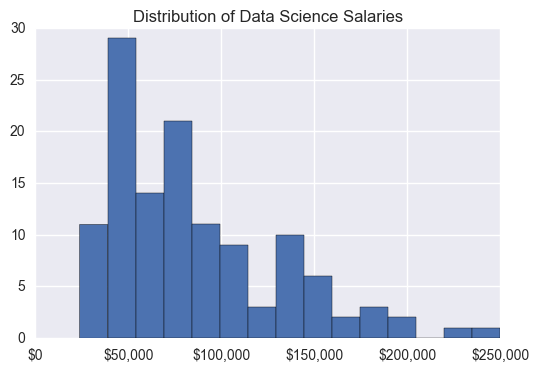

In [169]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)
formage = [i for i in range(50000,300000, 50000)]
formatter = FuncFormatter(millions)

fig, ax = plt.subplots()
plt.hist(new_df.salary, bins=15)
fmt = '${x:,.0f}'
tick = mlb.ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
plt.title("Distribution of Data Science Salaries")
# fig.savefig('hist_salaries_titled.pdf')
plt.show()

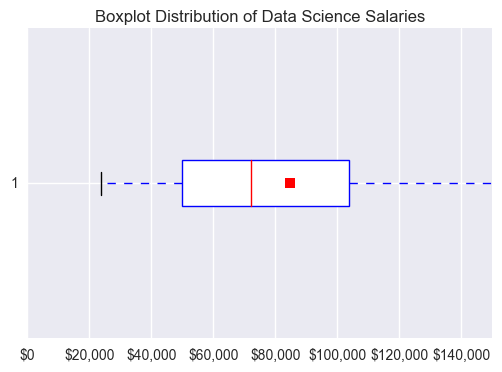

In [170]:
fig, ax = plt.subplots()
plt.boxplot(new_df.salary, showmeans=True, vert=False, patch_artist=True, showbox=True)
fmt = '${x:,.0f}'
tick = mlb.ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
plt.xlim(xmin = 0, xmax = 150000)
plt.title("Boxplot Distribution of Data Science Salaries")
# fig.savefig('boxplot_salaries.pdf')
plt.show()

In [171]:
# from pylab import figure, axes, pie, title, show
# plt.savefig('box_salaries.png', bbox_inches='tight')

### Save your results as a CSV

In [172]:
# new_df_csv = new_df.to_csv('Data Science Yearly Salaries Indeed.csv', encoding='utf-8')

In [173]:
# new_df_multi_csv = new_df_multi.to_csv('Multi Indexed Data Science Salaries.csv', encoding='utf-8')

## Predicting salaries using Logistic Regression

#### Load in the the data of scraped salaries

In [174]:
new_df_multi = new_df.set_index(['location', 'company'])

In [175]:
new_df_multi['salary_commas'] = new_df['salary'].astype(str)
new_df_multi['salary_commas'] = new_df_multi['salary'].apply(comma)
# new_df_multi['salary_commas'] = new_df['salary_commas'].apply(slip_dollar)

In [176]:
new_df_multi['salary_commas']= new_df_multi['salary_commas'].apply(slip_dollar)

In [177]:
new_df.location = split_city[0].str.cat(split_city[1])

In [178]:
new_df_multi.drop('summary', axis=1, inplace=True)

In [179]:
new_df_multi.sort_values(by='salary', ascending=False)

title  \
location          company                                                                                               
Houston,TX        Rekruiters                                                                    C++ Software Engineer   
Philadelphia,PA   PenfieldSearchPartners                                         Sr. Director, Statistical Innovation   
NewYork,          SelbyJennings                                            Quantitative Researcher – Machine Learning   
                  Harnham                                                                       Senior Data Scientist   
LosAngeles,       LT                                                                            Senior Data Scientist   
Chicago,IL        WorkbridgeAssociates                                                       Director of Data Science   
Dallas-FortWorth, OscarTechnology                                                               Data Science Director   
RedwoodCity,      ElevateRecruitingGroup                            Senior Data Scientist - Security Experience is...   
NewYork,          OliverJamesAssociates                             Program Manager - Data Science - New York City...   
Philadelphia,PA   Wolfe&HuntsmanLLC                                 Senior Business Systems Architect (Hadoop Deve...   
Houston,TX        SearchBankingJobs                                                         Quantitative Risk Analyst   
Phoenix,AZ        CareerEvolutions                                                                     Data Architect   
                  CareerEvolutions                                                             Data Services Engineer   
                  SearchAccountingJobs                                                   Quantitative Analyst Manager   
Dallas,TX         SelbyJennings                                             Quantitative Analyst - Multiple Vacancies   
SanFrancisco,     WorkbridgeAssociates                                           Senior Data Scientist (Optimization)   
Austin,TX         All-InAnalytics                                              Senior Machine Learning Data Scientist   
Philadelphia,PA   LibertyPersonnelServices                                              Quantitative Research Analyst   
NewYork,          HarrisAllied                                                     Quantitative Research/Data Analyst   
SanFrancisco,     WorkbridgeAssociates                                                          Senior Data Scientist   
NewYork,          SmithHanleyAssociates                                                      Director of Data Science   
SanFrancisco,     NisumTechnologies                                                         Big Data Talend Developer   
NewYork,          SelbyJennings                                                                 Senior Data Scientist   
                  Beeswax                                                              Senior / Director Data Science   
Chicago,IL        WorkbridgeAssociates                                                          Senior Data Scientist   
                  SilvaCapitalManagement                                                         Quantitative Analyst   
NewYork,          SelbyJennings                                             Quantitative Analyst - Multiple Vacancies   
LosAngeles,       SelbyJennings                                             Quantitative Analyst - Multiple Vacancies   
Denver,CO         10RoofTechnology                                           Big Data Developer (Spark, Hadoop, Hive)   
Atlanta,GA        CentersforDiseaseControlandPrevention                                    Lead Statistician (Health)   
...                                                                                                               ...   
Portland,OR       OregonHealth&ScienceUniversity                                              Postdoctoral Researcher  

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choice the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries, 

In [180]:
salaies_split = new_df.salary.quantile(0.75)

In [181]:
salaies_split

103674.5

In [182]:
def binary_conditioner(a):
    if a> salaies_split:
        return 1
    elif a < salaies_split:
        return 0

In [183]:
new_df['salaries_binary'] = new_df.salary.apply(binary_conditioner)

In [184]:
new_df.salaries_binary.value_counts()

0    92
1    31
Name: salaries_binary, dtype: int64

In [185]:
new_df['state'] = split_city[1]

In [186]:
state_dumb = pd.get_dummies(new_df.state)

In [187]:
state_dumb.AZ.name == 'AZ'

True

In [188]:
for i in state_dumb.columns:
    if len(state_dumb[i].name)>2:
        state_dumb.drop(i, axis=1, inplace=True)

In [189]:
df = pd.concat([new_df.salaries_binary,state_dumb], axis=1)

In [190]:
from sklearn.linear_model import LogisticRegression

In [191]:
new_df['city'] = split_city[0]
new_df.city = new_df.city.str.replace(',', '')

In [192]:
import statsmodels.formula.api as sm

In [193]:
col_needed = df.columns[1:]

In [194]:
df = df.dropna()

In [212]:
X = df[col_needed]
y = df['salaries_binary']

logreg = LogisticRegression()
model = logreg.fit(X, y)
X.columns, logreg.coef_

(Index([u'AZ', u'CA', u'CO', u'FL', u'GA', u'IL', u'NY', u'OR', u'PA', u'TX',
        u'WA'],
       dtype='object'),
 array([[-0.2548889 , -0.25105726, -0.79387088, -0.58217938, -0.49556153,
          0.92093178, -0.25105726, -0.97712056, -0.17888293, -0.19346953,
         -0.4359257 ]]))

In [213]:
print model

y_pred = model.predict(X)

print "Classification Report: \n", metrics.classification_report(y, y_pred)

print "Confusion Matrix:\n", metrics.confusion_matrix(y, y_pred)

print "Classification Scoring:"
print "Accuracy Score:", metrics.accuracy_score(y, y_pred)
print "AUC Score:", metrics.roc_auc_score(y, y_pred)
print "Precision Score:", metrics.precision_score(y, y_pred)
print "Recall Score:", metrics.recall_score(y, y_pred)
print "F1 Score:", metrics.f1_score(y, y_pred)

print "Regression Scoring:"
print "MAE:", metrics.mean_absolute_error(y, y_pred)
print "MSE:", metrics.mean_squared_error(y, y_pred)
print "R2:", metrics.r2_score(y, y_pred)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Classification Report: 
             precision    recall  f1-score   support

          0       0.76      0.99      0.86        92
          1       0.75      0.10      0.17        31

avg / total       0.76      0.76      0.69       123

Confusion Matrix:
[[91  1]
 [28  3]]
Classification Scoring:
Accuracy Score: 0.764227642276
AUC Score: 0.542952314165
Precision Score: 0.75
Recall Score: 0.0967741935484
F1 Score: 0.171428571429
Regression Scoring:
MAE: 0.235772357724
MSE: 0.235772357724
R2: -0.250701262272


#### Thought experiment: What is the baseline accuracy for this model?

In [196]:
## YOUR CODE HERE

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [221]:
new_df['senior'] = new_df['title'].str.contains('Senior')
new_df['manager'] = new_df['title'].str.contains('Manager')

X1 = new_df[['senior', 'manager']]
y = new_df.salaries_binary

model1 = LogisticRegression()
model1.fit(X1, y)
print model1

y_pred1 = model1.predict(X1)

print "Classification Report:"
print metrics.classification_report(y, y_pred1)

print "Confusion Matrix:"
print metrics.confusion_matrix(y, y_pred1)

print "Classification Scoring:"
print "Accuracy Score:", metrics.accuracy_score(y, y_pred1)
print "AUC Score:", metrics.roc_auc_score(y, y_pred1)
print "Precision Score:", metrics.precision_score(y, y_pred1)
print "Recall Score:", metrics.recall_score(y, y_pred1)
print "F1 Score:", metrics.f1_score(y, y_pred1)

print "Regression Scoring:"
print "MAE:", metrics.mean_absolute_error(y, y_pred1)
print "MSE:", metrics.mean_squared_error(y, y_pred1)
print "R2:", metrics.r2_score(y, y_pred1)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Classification Report:
             precision    recall  f1-score   support

          0       0.75      1.00      0.86        92
          1       0.00      0.00      0.00        31

avg / total       0.56      0.75      0.64       123

Confusion Matrix:
[[92  0]
 [31  0]]
Classification Scoring:
Accuracy Score: 0.747967479675
AUC Score: 0.5
Precision Score: 0.0
Recall Score: 0.0
F1 Score: 0.0
Regression Scoring:
MAE: 0.252032520325
MSE: 0.252032520325
R2: -0.336956521739


#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [199]:
## YOUR CODE HERE

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70)
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print "Classification Report:", metrics.classification_report(y_test, y_pred)

print "Confusion Matrix:", metrics.confusion_matrix(y_test, y_pred)

print "Classification Scoring:"
print "Accuracy Score:", metrics.accuracy_score(y_test, y_pred)
print "AUC Score:", metrics.roc_auc_score(y_test, y_pred)
print "Precision Score:", metrics.precision_score(y_test, y_pred)
print "Recall Score:", metrics.recall_score(y_test, y_pred)
print "F1 Score:", metrics.f1_score(y_test, y_pred)

print "Regression Scoring:"
print "MAE:", metrics.mean_absolute_error(y_test, y_pred)
print "MSE:", metrics.mean_squared_error(y_test, y_pred)
print "R2:", metrics.r2_score(y_test, y_pred)

Classification Report:              precision    recall  f1-score   support

          0       0.78      0.86      0.81        69
          1       0.09      0.06      0.07        18

avg / total       0.63      0.69      0.66        87

Confusion Matrix: [[59 10]
 [17  1]]
Classification Scoring:
Accuracy Score: 0.689655172414
AUC Score: 0.455314009662
Precision Score: 0.0909090909091
Recall Score: 0.0555555555556
F1 Score: 0.0689655172414
Regression Scoring:
MAE: 0.310344827586
MSE: 0.310344827586
R2: -0.891304347826


#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70)
lr = LogisticRegression(penalty='l1')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print "Classification Report:", metrics.classification_report(y_test, y_pred)

print "Confusion Matrix:", metrics.confusion_matrix(y_test, y_pred)

print "Classification Scoring:"
print "Accuracy Score:", metrics.accuracy_score(y_test, y_pred)
print "AUC Score:", metrics.roc_auc_score(y_test, y_pred)
print "Precision Score:", metrics.precision_score(y_test, y_pred)
print "Recall Score:", metrics.recall_score(y_test, y_pred)
print "F1 Score:", metrics.f1_score(y_test, y_pred)

print "Regression Scoring:"
print "MAE:", metrics.mean_absolute_error(y_test, y_pred)
print "MSE:", metrics.mean_squared_error(y_test, y_pred)
print "R2:", metrics.r2_score(y_test, y_pred)

Classification Report:              precision    recall  f1-score   support

          0       0.77      1.00      0.87        67
          1       0.00      0.00      0.00        20

avg / total       0.59      0.77      0.67        87

Confusion Matrix: [[67  0]
 [20  0]]
Classification Scoring:
Accuracy Score: 0.770114942529
AUC Score: 0.5
Precision Score: 0.0
Recall Score: 0.0
F1 Score: 0.0
Regression Scoring:
MAE: 0.229885057471
MSE: 0.229885057471
R2: -0.298507462687


In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70)
lr = LogisticRegression(penalty='l2')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print "Classification Report:", metrics.classification_report(y_test, y_pred)

print "Confusion Matrix:", metrics.confusion_matrix(y_test, y_pred)

print "Classification Scoring:"
print "Accuracy Score:", metrics.accuracy_score(y_test, y_pred)
print "AUC Score:", metrics.roc_auc_score(y_test, y_pred)
print "Precision Score:", metrics.precision_score(y_test, y_pred)
print "Recall Score:", metrics.recall_score(y_test, y_pred)
print "F1 Score:", metrics.f1_score(y_test, y_pred)

print "Regression Scoring:"
print "MAE:", metrics.mean_absolute_error(y_test, y_pred)
print "MSE:", metrics.mean_squared_error(y_test, y_pred)
print "R2:", metrics.r2_score(y_test, y_pred)

Classification Report:              precision    recall  f1-score   support

          0       0.75      1.00      0.86        65
          1       0.00      0.00      0.00        22

avg / total       0.56      0.75      0.64        87

Confusion Matrix: [[65  0]
 [22  0]]
Classification Scoring:
Accuracy Score: 0.747126436782
AUC Score: 0.5
Precision Score: 0.0
Recall Score: 0.0
F1 Score: 0.0
Regression Scoring:
MAE: 0.252873563218
MSE: 0.252873563218
R2: -0.338461538462


In [202]:
## YOUR CODE HERE

#### Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients

#### Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary - which entries have the highest predicted salaries?

### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [203]:
## YOUR CODE HERE

In [204]:
## YOUR CODE HERE

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [205]:
## YOUR CODE HERE